In [8]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from pathlib import Path


# Build robust path to data folder (notebooks and data are siblings)
DATA_DIR = Path.cwd().parent / 'data'
SUB_DIR = Path.cwd().parent / 'submissions'
train_path = DATA_DIR / 'train.csv'
test_path = DATA_DIR / 'test.csv'


# Load the datasets
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)  # This is for final predictions (no 'W' column)

# Display basic information about the datasets
print(f"Training set shape: {train_df.shape}")
print(f"Test set shape: {test_df.shape}")
print(f"'W' column in train dataset: {'W' in train_df.columns}")
print(f"'W' column in test dataset: {'W' in test_df.columns}")

Training set shape: (1812, 51)
Test set shape: (453, 45)
'W' column in train dataset: True
'W' column in test dataset: False


In [ ]:
# Create derived features for both train and test sets

# R_per_game: Runs per game
# RA_per_game: Runs allowed per game
train_df['R_per_game'] = train_df['R'] / train_df['G']
train_df['RA_per_game'] = train_df['RA'] / train_df['G']
test_df['R_per_game'] = test_df['R'] / test_df['G']
test_df['RA_per_game'] = test_df['RA'] / test_df['G']

print(f"\nCreated derived features: R_per_game, RA_per_game")
print(f"Train - R_per_game range: {train_df['R_per_game'].min():.3f} to {train_df['R_per_game'].max():.3f}")
print(f"Train - RA_per_game range: {train_df['RA_per_game'].min():.3f} to {train_df['RA_per_game'].max():.3f}")
print(f"Test - R_per_game range: {test_df['R_per_game'].min():.3f} to {test_df['R_per_game'].max():.3f}")
print(f"Test - RA_per_game range: {test_df['RA_per_game'].min():.3f} to {test_df['RA_per_game'].max():.3f}")

# Expected Wins of Season = G × (R²) / (R² + RA²)
train_df['Expected_Wins'] = train_df['G'] * (train_df['R_per_game'] ** 2) / ((train_df['R_per_game'] ** 2) + (train_df['RA_per_game'] ** 2))
test_df['Expected_Wins'] = test_df['G'] * (test_df['R_per_game'] ** 2) / ((test_df['R_per_game'] ** 2) + (test_df['RA_per_game'] ** 2))
# train_df['Expected_Wins'] = train_df['G'] * (train_df['R'] ** 2) / ((train_df['R'] ** 2) + (train_df['RA'] ** 2))
# test_df['Expected_Wins'] = test_df['G'] * (test_df['R'] ** 2) / ((test_df['R'] ** 2) + (test_df['RA'] ** 2))
print(f"\nCreated derived feature: Expected_Wins")   
print(f"Train - Expected_Wins range: {train_df['Expected_Wins'].min():.3f} to {train_df['Expected_Wins'].max():.3f}")
print(f"Test - Expected_Wins range: {test_df['Expected_Wins'].min():.3f} to {test_df['Expected_Wins'].max():.3f}")

# Times getting on base
train_df['Times_On_Base'] = train_df['H'] + train_df['BB']
test_df['Times_On_Base'] = test_df['H'] + test_df['BB']

print(f"\nCreated derived feature: Times_On_Base")
print(f"Train - Times_On_Base range: {train_df['Times_On_Base'].min():.3f} to {train_df['Times_On_Base'].max():.3f}")
print(f"Test - Times_On_Base range: {test_df['Times_On_Base'].min():.3f} to {test_df['Times_On_Base'].max():.3f}")

# BB Rate (Walk Percentage) - BB / AB + BB
train_df['BB_Rate'] = train_df['BB'] / (train_df['AB'] + train_df['BB'])
test_df['BB_Rate'] = test_df['BB'] / (test_df['AB'] + test_df['BB'])

print(f"\nCreated derived feature: BB_Rate")
print(f"Train - BB_Rate range: {train_df['BB_Rate'].min():.3f} to {train_df['BB_Rate'].max():.3f}") 
print(f"Test - BB_Rate range: {test_df['BB_Rate'].min():.3f} to {test_df['BB_Rate'].max():.3f}")

# Home Run Rate - HR / AB
train_df['HR_Rate'] = train_df['HR'] / train_df['AB']
test_df['HR_Rate'] = test_df['HR'] / test_df['AB']

print(f"\nCreated derived feature: HR_Rate")
print(f"Train - HR_Rate range: {train_df['HR_Rate'].min():.3f} to {train_df['HR_Rate'].max():.3f}")
print(f"Test - HR_Rate range: {test_df['HR_Rate'].min():.3f} to {test_df['HR_Rate'].max():.3f}")

# On-Base Percentage (OBP) - (H + BB) / (AB + BB)
train_df['OBP'] = (train_df['H'] + train_df['BB']) / (train_df['AB'] + train_df['BB'])
test_df['OBP'] = (test_df['H'] + test_df['BB']) / (test_df['AB'] + test_df['BB'])

print(f"\nCreated derived feature: OBP")
print(f"Train - OBP range: {train_df['OBP'].min():.3f} to {train_df['OBP'].max():.3f}") 
print(f"Test - OBP range: {test_df['OBP'].min():.3f} to {test_df['OBP'].max():.3f}")

# Slugging Percentage (SLG)
# Singles = H - (2B + 3B + HR)
# Total Bases = Singles + (2 * 2B) + (3 * 3B) + (4 * HR)
# SLG = Total Bases / AB
Singles_train = train_df['H'] - (train_df['2B'] + train_df['3B'] + train_df['HR'])
Total_Bases_train = Singles_train + (2 * train_df['2B']) + (3 * train_df['3B']) + (4 * train_df['HR'])
train_df['SLG'] = Total_Bases_train / train_df['AB']  

Singles_test = test_df['H'] - (test_df['2B'] + test_df['3B'] + test_df['HR'])
Total_Bases_test = Singles_test + (2 * test_df['2B']) + (3 * test_df['3B']) + (4 * test_df['HR'])
test_df['SLG'] = Total_Bases_test / test_df['AB']

print(f"\nCreated derived feature: SLG")
print(f"Train - SLG range: {train_df['SLG'].min():.3f} to {train_df['SLG'].max():.3f}") 
print(f"Test - SLG range: {test_df['SLG'].min():.3f} to {test_df['SLG'].max():.3f}")    

# Combined On-Base Plus Slugging (OPS) - OBP + SLG
train_df['OPS'] = train_df['OBP'] + train_df['SLG']
test_df['OPS'] = test_df['OBP'] + test_df['SLG']

print(f"\nCreated derived feature: OPS")
print(f"Train - OPS range: {train_df['OPS'].min():.3f} to {train_df['OPS'].max():.3f}") 
print(f"Test - OPS range: {test_df['OPS'].min():.3f} to {test_df['OPS'].max():.3f}")

# Time on Base Allowed - HA + BBA
train_df['Times_On_Base_Allowed'] = train_df['HA'] + train_df['BBA']
test_df['Times_On_Base_Allowed'] = test_df['HA'] + test_df['BBA']

print(f"\nCreated derived feature: Times_On_Base_Allowed")
print(f"Train - Times_On_Base_Allowed range: {train_df['Times_On_Base_Allowed'].min():.3f} to {train_df['Times_On_Base_Allowed'].max():.3f}")
print(f"Test - Times_On_Base_Allowed range: {test_df['Times_On_Base_Allowed'].min():.3f} to {test_df['Times_On_Base_Allowed'].max():.3f}")

# WHIP (Walks plus Hits per Inning Pitched)
# Inings Pitched = IPouts / 3
# Times_On_Base_Per_Inning = Times_On_Base_Allowed / Inings_Pitched
train_df['Innings_Pitched'] = train_df['IPouts'] / 3
train_df['WHIP'] = train_df['Times_On_Base_Allowed'] / train_df['Innings_Pitched']
test_df['Innings_Pitched'] = test_df['IPouts'] / 3
test_df['WHIP'] = test_df['Times_On_Base_Allowed'] / test_df['Innings_Pitched']

print(f"\nCreated derived feature: WHIP")
print(f"Train - WHIP range: {train_df['WHIP'].min():.3f} to {train_df['WHIP'].max():.3f}")
print(f"Test - WHIP range: {test_df['WHIP'].min():.3f} to {test_df['WHIP'].max():.3f}")

# K/9 (Strikeouts per 9 Innings) - SOA / Innings_Pitched * 9
train_df['K_per_9'] = (train_df['SOA'] / train_df['Innings_Pitched']) * 9
test_df['K_per_9'] = (test_df['SOA'] / test_df['Innings_Pitched']) * 9  

print(f"\nCreated derived feature: K_per_9")
print(f"Train - K_per_9 range: {train_df['K_per_9'].min():.3f} to {train_df['K_per_9'].max():.3f}")
print(f"Test - K_per_9 range: {test_df['K_per_9'].min():.3f} to {test_df['K_per_9'].max():.3f}")

# HR/9 (Home Runs Allowed per 9 Innings) - HRA / Innings_Pitched * 9
train_df['HR_per_9'] = (train_df['HRA'] / train_df['Innings_Pitched']) * 9
test_df['HR_per_9'] = (test_df['HRA'] / test_df['Innings_Pitched']) * 9

print(f"\nCreated derived feature: HR_per_9")
print(f"Train - HR_per_9 range: {train_df['HR_per_9'].min():.3f} to {train_df['HR_per_9'].max():.3f}")
print(f"Test - HR_per_9 range: {test_df['HR_per_9'].min():.3f} to {test_df['HR_per_9'].max():.3f}")

# Run Environment Idex (REI) - (R + RA) / G / mlb_rpg
train_df['REI'] = (train_df['R'] + train_df['RA']) / train_df['G'] / train_df['mlb_rpg']
test_df['REI'] = (test_df['R'] + test_df['RA']) / test_df['G'] / test_df['mlb_rpg']
print(f"\nCreated derived feature: REI")
print(f"Train - REI range: {train_df['REI'].min():.3f} to {train_df['REI'].max():.3f}")
print(f"Test - REI range: {test_df['REI'].min():.3f} to {test_df['REI'].max():.3f}")    

# Power Environement Index (PEI) -  (HR + HRA) / G / (mlb_rpg * avg_hr_rate)
avg_hr_rate = train_df['HR_Rate'].mean()
train_df['PEI'] = (train_df['HR'] + train_df['HRA']) / train_df['G'] / (train_df['mlb_rpg'] * avg_hr_rate)
test_df['PEI'] = (test_df['HR'] + test_df['HRA']) / test_df['G'] / (test_df['mlb_rpg'] * avg_hr_rate)
print(f"\nCreated derived feature: PEI")
print(f"Train - PEI range: {train_df['PEI'].min():.3f} to {train_df['PEI'].max():.3f}")
print(f"Test - PEI range: {test_df['PEI'].min():.3f} to {test_df['PEI'].max():.3f}") 

# Era adjusted OBP, SLG, OPS, WHIP, K_per_9, HR_per_9, BB_Rate, HR_Rate
# Historical average runs per game (RPG) for MLB
historical_avg_rpg_train = train_df['mlb_rpg'].mean()
historical_avg_rpg_test = test_df['mlb_rpg'].mean()

# Era adjusted OBP
train_df['Era_Adjusted_OBP'] = train_df['OBP'] * (historical_avg_rpg_train / train_df['mlb_rpg'])
test_df['Era_Adjusted_OBP'] = test_df['OBP'] * (historical_avg_rpg_test / test_df['mlb_rpg'])
print(f"\nCreated derived feature: Era_Adjusted_OBP")
print(f"Train - Era_Adjusted_OBP range: {train_df['Era_Adjusted_OBP'].min():.3f} to {train_df['Era_Adjusted_OBP'].max():.3f}") 
print(f"Test - Era_Adjusted_OBP range: {test_df['Era_Adjusted_OBP'].min():.3f} to {test_df['Era_Adjusted_OBP'].max():.3f}") 

# Era adjusted SLG
train_df['Era_Adjusted_SLG'] = train_df['SLG'] * (historical_avg_rpg_train / train_df['mlb_rpg'])
test_df['Era_Adjusted_SLG'] = test_df['SLG'] * (historical_avg_rpg_test / test_df['mlb_rpg'])
print(f"\nCreated derived feature: Era_Adjusted_SLG")
print(f"Train - Era_Adjusted_SLG range: {train_df['Era_Adjusted_SLG'].min():.3f} to {train_df['Era_Adjusted_SLG'].max():.3f}") 
print(f"Test - Era_Adjusted_SLG range: {test_df['Era_Adjusted_SLG'].min():.3f} to {test_df['Era_Adjusted_SLG'].max():.3f}") 

# Era adjusted OPS
train_df['Era_Adjusted_OPS'] = train_df['OPS'] * (historical_avg_rpg_train / train_df['mlb_rpg'])
test_df['Era_Adjusted_OPS'] = test_df['OPS'] * (historical_avg_rpg_test / test_df['mlb_rpg'])
print(f"\nCreated derived feature: Era_Adjusted_OPS")
print(f"Train - Era_Adjusted_OPS range: {train_df['Era_Adjusted_OPS'].min():.3f} to {train_df['Era_Adjusted_OPS'].max():.3f}") 
print(f"Test - Era_Adjusted_OPS range: {test_df['Era_Adjusted_OPS'].min():.3f} to {test_df['Era_Adjusted_OPS'].max():.3f}")

# Era adjusted WHIP
train_df['Era_Adjusted_WHIP'] = train_df['WHIP'] * (historical_avg_rpg_train / train_df['mlb_rpg'])
test_df['Era_Adjusted_WHIP'] = test_df['WHIP'] * (historical_avg_rpg_test / test_df['mlb_rpg'])
print(f"\nCreated derived feature: Era_Adjusted_WHIP")
print(f"Train - Era_Adjusted_WHIP range: {train_df['Era_Adjusted_WHIP'].min():.3f} to {train_df['Era_Adjusted_WHIP'].max():.3f}")
print(f"Test - Era_Adjusted_WHIP range: {test_df['Era_Adjusted_WHIP'].min():.3f} to {test_df['Era_Adjusted_WHIP'].max():.3f}")

# Era adjusted K_per_9
train_df['Era_Adjusted_K_per_9'] = train_df['K_per_9'] * (historical_avg_rpg_train / train_df['mlb_rpg'])
test_df['Era_Adjusted_K_per_9'] = test_df['K_per_9'] * (historical_avg_rpg_test / test_df['mlb_rpg'])
print(f"\nCreated derived feature: Era_Adjusted_K_per_9")
print(f"Train - Era_Adjusted_K_per_9 range: {train_df['Era_Adjusted_K_per_9'].min():.3f} to {train_df['Era_Adjusted_K_per_9'].max():.3f}")
print(f"Test - Era_Adjusted_K_per_9 range: {test_df['Era_Adjusted_K_per_9'].min():.3f} to {test_df['Era_Adjusted_K_per_9'].max():.3f}") 

# Era adjusted HR_per_9
train_df['Era_Adjusted_HR_per_9'] = train_df['HR_per_9'] * (historical_avg_rpg_train / train_df['mlb_rpg'])
test_df['Era_Adjusted_HR_per_9'] = test_df['HR_per_9'] * (historical_avg_rpg_test / test_df['mlb_rpg'])
print(f"\nCreated derived feature: Era_Adjusted_HR_per_9")
print(f"Train - Era_Adjusted_HR_per_9 range: {train_df['Era_Adjusted_HR_per_9'].min():.3f} to {train_df['Era_Adjusted_HR_per_9'].max():.3f}")
print(f"Test - Era_Adjusted_HR_per_9 range: {test_df['Era_Adjusted_HR_per_9'].min():.3f} to {test_df['Era_Adjusted_HR_per_9'].max():.3f}")

# Era adjusted BB_Rate
train_df['Era_Adjusted_BB_Rate'] = train_df['BB_Rate'] * (historical_avg_rpg_train / train_df['mlb_rpg'])
test_df['Era_Adjusted_BB_Rate'] = test_df['BB_Rate'] * (historical_avg_rpg_test / test_df['mlb_rpg'])
print(f"\nCreated derived feature: Era_Adjusted_BB_Rate")
print(f"Train - Era_Adjusted_BB_Rate range: {train_df['Era_Adjusted_BB_Rate'].min():.3f} to {train_df['Era_Adjusted_BB_Rate'].max():.3f}")
print(f"Test - Era_Adjusted_BB_Rate range: {test_df['Era_Adjusted_BB_Rate'].min():.3f} to {test_df['Era_Adjusted_BB_Rate'].max():.3f}") 

# Era adjusted HR_Rate
train_df['Era_Adjusted_HR_Rate'] = train_df['HR_Rate'] * (historical_avg_rpg_train / train_df['mlb_rpg'])
test_df['Era_Adjusted_HR_Rate'] = test_df['HR_Rate'] * (historical_avg_rpg_test / test_df['mlb_rpg'])
print(f"\nCreated derived feature: Era_Adjusted_HR_Rate")
print(f"Train - Era_Adjusted_HR_Rate range: {train_df['Era_Adjusted_HR_Rate'].min():.3f} to {train_df['Era_Adjusted_HR_Rate'].max():.3f}")
print(f"Test - Era_Adjusted_HR_Rate range: {test_df['Era_Adjusted_HR_Rate'].min():.3f} to {test_df['Era_Adjusted_HR_Rate'].max():.3f}")



Created derived features: R_per_game, RA_per_game
Train - R_per_game range: 2.409 to 6.884
Train - RA_per_game range: 2.458 to 7.686
Test - R_per_game range: 2.783 to 6.896
Test - RA_per_game range: 2.867 to 6.865

Created derived feature: Expected_Wins
Train - Expected_Wins range: 35.860 to 119.963
Test - Expected_Wins range: 40.352 to 107.111

Created derived feature: Times_On_Base
Train - Times_On_Base range: 1367.000 to 2415.000
Test - Times_On_Base range: 1453.000 to 2327.000

Created derived feature: BB_Rate
Train - BB_Rate range: 0.051 to 0.136
Test - BB_Rate range: 0.052 to 0.123

Created derived feature: HR_Rate
Train - HR_Rate range: 0.001 to 0.047
Test - HR_Rate range: 0.001 to 0.045

Created derived feature: OBP
Train - OBP range: 0.262 to 0.382
Test - OBP range: 0.267 to 0.382

Created derived feature: SLG
Train - SLG range: 0.274 to 0.491
Test - SLG range: 0.261 to 0.488

Created derived feature: OPS
Train - OPS range: 0.539 to 0.870
Test - OPS range: 0.530 to 0.870

Cre

In [ ]:
# Select only the default features from DATA_DESCRIPTION.md
default_features = [
    # Basic Statistics
    'G', 'R', 'AB', 'H', '2B', '3B', 'HR', 'BB', 'SO', 'SB', 'CS', 'HBP', 'SF',
    'RA', 'ER', 'ERA', 'CG', 'SHO', 'SV', 'IPouts', 'HA', 'HRA', 'BBA', 'SOA',
    'E', 'DP', 'FP', 'attendance', 'BPF', 'PPF',
    
    # Derived Features
    'Expected_Wins', 'Times_On_Base', 'Times_On_Base_Allowed', 'mlb_rpg',
    
    # 'Era_Adjusted_OBP', 'Era_Adjusted_SLG', 'Era_Adjusted_OPS', 'Era_Adjusted_WHIP',
    # 'Era_Adjusted_K_per_9', 'Era_Adjusted_HR_per_9', 'Era_Adjusted_BB_Rate', 'Era_Adjusted_HR_Rate',
    'BB_Rate', 'HR_Rate', 'OBP', 'SLG', 'OPS', 'WHIP', 'K_per_9', 'HR_per_9',

    # 'PEI', 'REI',
    
    # Era Indicators
    'era_1', 'era_2', 'era_3', 'era_4', 'era_5', 'era_6', 'era_7', 'era_8',
    
    # Decade Indicators
    'decade_1910', 'decade_1920', 'decade_1930', 'decade_1940', 'decade_1950',
    'decade_1960', 'decade_1970', 'decade_1980', 'decade_1990', 'decade_2000', 'decade_2010'
 ]


# Filter features that exist in both training data AND test data
available_features = [col for col in default_features 
                     if col in train_df.columns and col in test_df.columns]
print(f"Number of available default features: {len(available_features)}")

# Print available features in a column
print("Available features:")
for feature in available_features:
    print(feature)


Number of available default features: 53
Available features:
G
R
AB
H
2B
3B
HR
BB
SO
SB
RA
ER
ERA
CG
SHO
SV
IPouts
HA
HRA
BBA
SOA
E
DP
FP
Expected_Wins
Times_On_Base
BB_Rate
HR_Rate
OPS
Times_On_Base_Allowed
WHIP
K_per_9
HR_per_9
mlb_rpg
era_1
era_2
era_3
era_4
era_5
era_6
era_7
era_8
decade_1910
decade_1920
decade_1930
decade_1940
decade_1950
decade_1960
decade_1970
decade_1980
decade_1990
decade_2000
decade_2010


In [11]:
# Prepare training data (split the train.csv for model evaluation)
X_full = train_df[available_features]
y_full = train_df['W']

# Split training data into train/validation sets for model evaluation
X_train, X_val, y_train, y_val = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42
)

# Prepare final test data for predictions (this has no target variable)
X_test_final = test_df[available_features]

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Final test set shape: {X_test_final.shape}")

Training set shape: (1449, 53)
Validation set shape: (363, 53)
Final test set shape: (453, 53)



Scaling Numeric Features...

Training Linear Regression Model...

Linear Regression Performance:
  Training MAE: 2.6101
  Validation MAE: 2.8265
  Validation RMSE: 3.5371
  Validation R²: 0.9221

Top 10 Most Important Features:
          Feature  Coefficient
28            OPS    12.360619
31        K_per_9     8.457462
20            SOA    -8.320460
26        BB_Rate    -8.247497
32       HR_per_9    -7.857131
18            HRA     7.408954
27        HR_Rate    -7.274337
16         IPouts     6.354159
7              BB     5.910339
24  Expected_Wins     5.764564


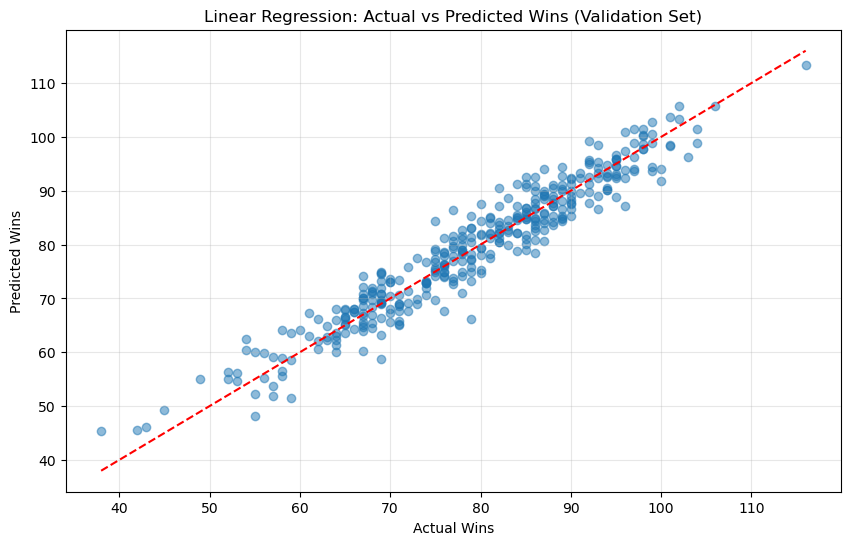

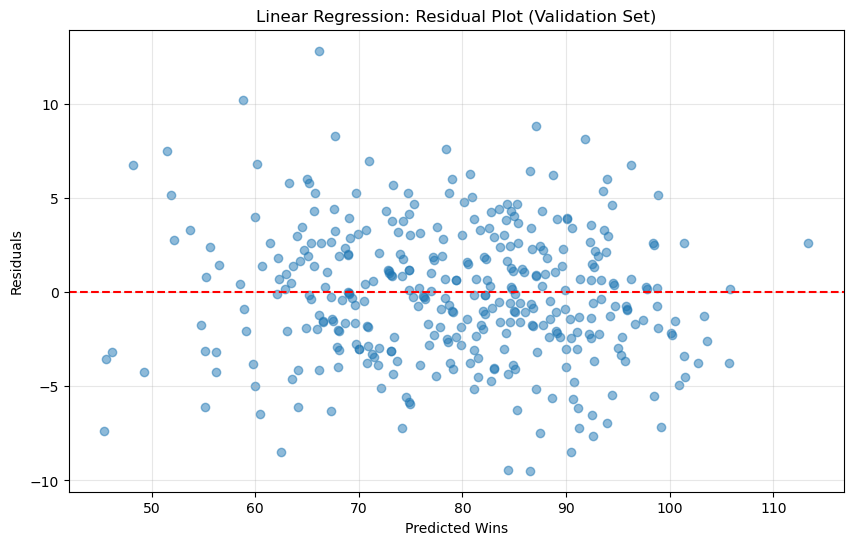


Generated 453 predictions for the test set
Prediction range: 44.29 to 109.61

Submission dataframe shape: (453, 2)
First few predictions:
     ID          W
0  1756  70.184575
1  1282  74.780741
2   351  84.372572
3   421  87.044638
4    57  93.568743


In [12]:
# Linear Regression Model with Standard Scaling

# Import necessary libraries
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression


print("\nScaling Numeric Features...")
# Scale features
# Identify columns to exclude from scaling (one-hot encoded and label columns)
one_hot_cols = [col for col in X_train.columns if col.startswith(('era_', 'decade_'))]
other_cols = [col for col in X_train.columns if col not in one_hot_cols]


# Scale only non-one-hot features
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_test_final_scaled = X_test_final.copy()

X_train_scaled[other_cols] = scaler.fit_transform(X_train[other_cols])
X_val_scaled[other_cols] = scaler.transform(X_val[other_cols])
X_test_final_scaled[other_cols] = scaler.transform(X_test_final[other_cols])

print("\nTraining Linear Regression Model...")
# Linear Regression Model
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
lr_train_preds = lr.predict(X_train_scaled)
lr_val_preds = lr.predict(X_val_scaled)
lr_test_final_preds = lr.predict(X_test_final_scaled)


# Evaluate Linear Regression (using validation set)
lr_train_mae = mean_absolute_error(y_train, lr_train_preds)
lr_val_mae = mean_absolute_error(y_val, lr_val_preds)
lr_val_rmse = np.sqrt(mean_squared_error(y_val, lr_val_preds))
lr_val_r2 = r2_score(y_val, lr_val_preds)


print(f"\nLinear Regression Performance:")
print(f"  Training MAE: {lr_train_mae:.4f}")
print(f"  Validation MAE: {lr_val_mae:.4f}")
print(f"  Validation RMSE: {lr_val_rmse:.4f}")
print(f"  Validation R²: {lr_val_r2:.4f}")


# Feature importance from Linear Regression
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lr.coef_
}).sort_values('Coefficient', key=abs, ascending=False)


print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))


# Visualize actual vs predicted values (using validation set)
plt.figure(figsize=(10, 6))
plt.scatter(y_val, lr_val_preds, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel('Actual Wins')
plt.ylabel('Predicted Wins')
plt.title('Linear Regression: Actual vs Predicted Wins (Validation Set)')
plt.grid(True, alpha=0.3)
plt.show()


# Add residual plot (using validation set)
plt.figure(figsize=(10, 6))
residuals = y_val - lr_val_preds
plt.scatter(lr_val_preds, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Wins')
plt.ylabel('Residuals')
plt.title('Linear Regression: Residual Plot (Validation Set)')
plt.grid(True, alpha=0.3)
plt.show()


# Generate predictions for the final test set (for submission)
print(f"\nGenerated {len(lr_test_final_preds)} predictions for the test set")
print(f"Prediction range: {lr_test_final_preds.min():.2f} to {lr_test_final_preds.max():.2f}")

# Create submission dataframe
submission_df = pd.DataFrame({
    'ID': test_df['ID'],
    'W': lr_test_final_preds
})

print(f"\nSubmission dataframe shape: {submission_df.shape}")
print("First few predictions:")
print(submission_df.head())

# # Save submission to CSV with timestamp
# from datetime import datetime
# timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
# submission_filename = f'submission_starter_derived_linear_regression_{timestamp}.csv'
# submission_path = SUB_DIR / submission_filename
# submission_df.to_csv(submission_path, index=False)
# print(f"\nSubmission saved to: {submission_path}")
# print(f"File: {submission_filename}")

In [13]:
# # Cat Boost Model

# # Import necessary libraries
# from catboost import CatBoostRegressor

# # CatBoost Model (no scaling needed - tree-based models don't require scaling)
# print("\nTraining CatBoost model...")
# cb = CatBoostRegressor(
#     iterations=1000,
#     learning_rate=0.05,
#     depth=6,
#     loss_function='RMSE',
#     eval_metric='RMSE',
#     random_seed=42,
#     verbose=100
# )

# cb.fit(
#     X_train, y_train,
#     eval_set=(X_val, y_val),
#     early_stopping_rounds=50,
#     verbose=100
# )

# # Make predictions
# cb_train_preds = cb.predict(X_train)
# cb_val_preds = cb.predict(X_val)
# cb_test_final_preds = cb.predict(X_test_final)


# # Evaluate CatBoost (using validation set)
# cb_train_mae = mean_absolute_error(y_train, cb_train_preds)
# cb_val_mae = mean_absolute_error(y_val, cb_val_preds)
# cb_val_rmse = np.sqrt(mean_squared_error(y_val, cb_val_preds))
# cb_val_r2 = r2_score(y_val, cb_val_preds)


# print(f"\nCatBoost Performance:")
# print(f"  Training MAE: {cb_train_mae:.4f}")
# print(f"  Validation MAE: {cb_val_mae:.4f}")
# print(f"  Validation RMSE: {cb_val_rmse:.4f}")
# print(f"  Validation R²: {cb_val_r2:.4f}")


# # Feature importance from CatBoost
# feature_importance = pd.DataFrame({
#     'Feature': X_train.columns,
#     'Importance': cb.feature_importances_
# }).sort_values('Importance', ascending=False)


# print("\nTop 10 Most Important Features:")
# print(feature_importance.head(10))


# # Visualize actual vs predicted values (using validation set)
# plt.figure(figsize=(10, 6))
# plt.scatter(y_val, cb_val_preds, alpha=0.5)
# plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
# plt.xlabel('Actual Wins')
# plt.ylabel('Predicted Wins')
# plt.title('CatBoost: Actual vs Predicted Wins (Validation Set)')
# plt.grid(True, alpha=0.3)
# plt.show()


# # Add residual plot (using validation set)
# plt.figure(figsize=(10, 6))
# residuals = y_val - cb_val_preds
# plt.scatter(cb_val_preds, residuals, alpha=0.5)
# plt.axhline(y=0, color='r', linestyle='--')
# plt.xlabel('Predicted Wins')
# plt.ylabel('Residuals')
# plt.title('CatBoost: Residual Plot (Validation Set)')
# plt.grid(True, alpha=0.3)
# plt.show()


# # Generate predictions for the final test set (for submission)
# print(f"\nGenerated {len(cb_test_final_preds)} predictions for the test set")
# print(f"Prediction range: {cb_test_final_preds.min():.2f} to {cb_test_final_preds.max():.2f}")

# # Create submission dataframe
# submission_df = pd.DataFrame({
#     'ID': test_df['ID'],
#     'W': cb_test_final_preds
# })

# print(f"\nSubmission dataframe shape: {submission_df.shape}")
# print("First few predictions:")
# print(submission_df.head())

# # # Save submission to CSV with timestamp
# # from datetime import datetime
# # timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
# # submission_filename = f'submission_starter_derived_catboost_{timestamp}.csv'
# # submission_path = SUB_DIR / submission_filename
# # submission_df.to_csv(submission_path, index=False)
# # print(f"\nSubmission saved to: {submission_path}")
# # print(f"File: {submission_filename}")

In [14]:
# # XGBoost Model

# # Import necessary libraries
# from catboost import CatBoostRegressor

# # CatBoost Model (no scaling needed - tree-based models don't require scaling)
# print("\nTraining CatBoost model...")
# cb = CatBoostRegressor(
#     iterations=1000,
#     learning_rate=0.05,
#     depth=6,
#     loss_function='RMSE',
#     eval_metric='RMSE',
#     random_seed=42,
#     verbose=100
# )

# cb.fit(
#     X_train, y_train,
#     eval_set=(X_val, y_val),
#     early_stopping_rounds=50,
#     verbose=100
# )

# # Make predictions
# cb_train_preds = cb.predict(X_train)
# cb_val_preds = cb.predict(X_val)
# cb_test_final_preds = cb.predict(X_test_final)


# # Evaluate CatBoost (using validation set)
# cb_train_mae = mean_absolute_error(y_train, cb_train_preds)
# cb_val_mae = mean_absolute_error(y_val, cb_val_preds)
# cb_val_rmse = np.sqrt(mean_squared_error(y_val, cb_val_preds))
# cb_val_r2 = r2_score(y_val, cb_val_preds)


# print(f"\nCatBoost Performance:")
# print(f"  Training MAE: {cb_train_mae:.4f}")
# print(f"  Validation MAE: {cb_val_mae:.4f}")
# print(f"  Validation RMSE: {cb_val_rmse:.4f}")
# print(f"  Validation R²: {cb_val_r2:.4f}")


# # Feature importance from CatBoost
# feature_importance = pd.DataFrame({
#     'Feature': X_train.columns,
#     'Importance': cb.feature_importances_
# }).sort_values('Importance', ascending=False)


# print("\nTop 10 Most Important Features:")
# print(feature_importance.head(10))


# # Visualize actual vs predicted values (using validation set)
# plt.figure(figsize=(10, 6))
# plt.scatter(y_val, cb_val_preds, alpha=0.5)
# plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
# plt.xlabel('Actual Wins')
# plt.ylabel('Predicted Wins')
# plt.title('CatBoost: Actual vs Predicted Wins (Validation Set)')
# plt.grid(True, alpha=0.3)
# plt.show()


# # Add residual plot (using validation set)
# plt.figure(figsize=(10, 6))
# residuals = y_val - cb_val_preds
# plt.scatter(cb_val_preds, residuals, alpha=0.5)
# plt.axhline(y=0, color='r', linestyle='--')
# plt.xlabel('Predicted Wins')
# plt.ylabel('Residuals')
# plt.title('CatBoost: Residual Plot (Validation Set)')
# plt.grid(True, alpha=0.3)
# plt.show()


# # Generate predictions for the final test set (for submission)
# print(f"\nGenerated {len(cb_test_final_preds)} predictions for the test set")
# print(f"Prediction range: {cb_test_final_preds.min():.2f} to {cb_test_final_preds.max():.2f}")

# # Create submission dataframe
# submission_df = pd.DataFrame({
#     'ID': test_df['ID'],
#     'W': cb_test_final_preds
# })

# print(f"\nSubmission dataframe shape: {submission_df.shape}")
# print("First few predictions:")
# print(submission_df.head())

# # Save submission to CSV with timestamp
# from datetime import datetime
# timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
# submission_filename = f'submission_starter_derived_catboost_{timestamp}.csv'
# submission_path = SUB_DIR / submission_filename
# submission_df.to_csv(submission_path, index=False)
# print(f"\nSubmission saved to: {submission_path}")
# print(f"File: {submission_filename}")